In [1]:
%%capture
%pip install neqsim

#To check for methods in a Java object 
#from neqsim import methods

# Experimental data
Experimental data for density of TEG is collected.

In [2]:
import pandas as pd
expdata_df = pd.read_csv('../../../data/thermodynamics/density/TEG.csv')
expdata_df

,ID,StandardDeviation,Temperature,ComponentName,Density,Pressure,PhaseType,Reference,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,30,11,298.15,TEG,1119.90,1.01325,liquid,Begum,NaN,NaN,NaN,NaN
1,31,11,303.15,TEG,1115.80,1.01325,liquid,Begum,NaN,NaN,NaN,NaN
2,32,11,308.15,TEG,1111.90,1.01325,liquid,Begum,NaN,NaN,NaN,NaN
3,33,11,313.15,TEG,1108.40,1.01325,liquid,Begum,NaN,NaN,NaN,NaN
4,34,11,318.15,TEG,1104.00,1.01325,liquid,Begum,NaN,NaN,NaN,NaN
5,35,11,323.15,TEG,1100.00,1.01325,liquid,Begum,NaN,NaN,NaN,NaN
6,36,11,328.14,TEG,1096.45,1.01325,liquid,Begum,NaN,NaN,NaN,NaN
7,37,11,338.15,TEG,1088.58,1.01325,liquid,Begum,NaN,NaN,NaN,NaN
8,38,11,348.14,TEG,1080.66,1.01325,liquid,Begum,NaN,NaN,NaN,NaN
9,39,11,358.15,TEG,1072.69,1.01325,liquid,Begum,NaN,NaN,NaN,NaN


<Figure size 640x480 with 0 Axes>

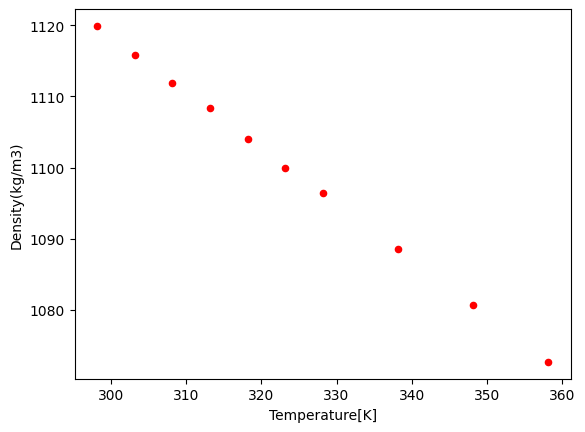

In [3]:
from matplotlib import pyplot as plt
fig = plt.figure()

expdata_df.plot(x='Temperature', y='Density', kind='scatter',ylabel='Density(kg/m3)', xlabel='Temperature[K]',color='red')

plt.show()

# Evaluation of experimental data

In this section the experimental data will be evaluated and eventual some data sets will be removed from the set.

# Compare to NeqSim Calculations

## NeqSim calculations at 288.15 K

 TC  769.5
 PC  33.13


<Figure size 640x480 with 0 Axes>

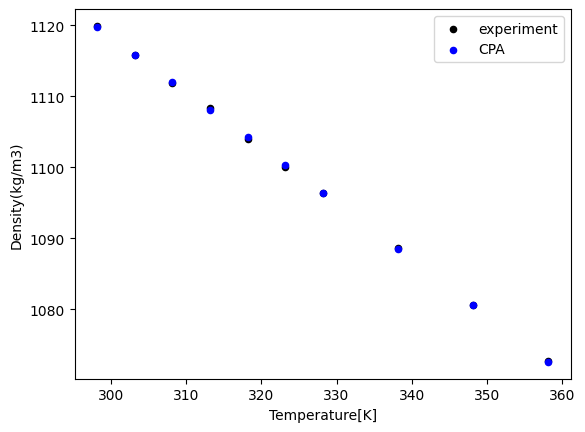

In [4]:
import neqsim
from neqsim.thermo.thermoTools import fluid, TPflash, fluidComposition,bubp
import pandas as pd
import numpy as np

fluid1 = fluid('cpa')
fluid1.addComponent('TEG', 1.0)
fluid1.setTemperature(15.0, 'C')
fluid1.setPressure(1.0, 'bara')

def density(temp):
    fluid1.setTemperature(temp, 'K')
    TPflash(fluid1)
    fluid1.initProperties()
    return fluid1.getPhase('aqueous').getDensity('kg/m3')

temperatures = expdata_df['Temperature'].values.tolist()
dens_res = [density(T) for T in temperatures]

dataWithExperiment = expdata_df.assign(dens_CPA = dens_res)

from matplotlib import pyplot as plt
fig = plt.figure()	
plot1 = dataWithExperiment.plot(x='Temperature', y='Density', kind='scatter',ylabel='Density(kg/m3)', xlabel='Temperature[K]',color='black')	
dataWithExperiment.plot(ax=plot1, x='Temperature', y='dens_CPA', kind='scatter',ylabel='Density(kg/m3)', xlabel='Temperature[K]',color='blue')	
plt.legend(['experiment', 'CPA'])
plt.show()

# Parameter fitting

## Manual fitting

 TC  769.5
 PC  33.13
Mat Cop Paramters 1  0.903477158616734 Mat Cop Paramters 2  1.514853438 Mat Cop Paramters 3  -1.86430399826
Racket CPA  0.284542458
vol corr T_CPA  -0.004423613
org cpa dens  0.00014144780708717994  ,m3/mol
volcorr = a +b(T-288.15)
a  7.768293012351008e-06  m3/mol
b  -0.004423613 m3/mol/K
vol corr  7.325931712351008e-06  m3/mol


<Figure size 640x480 with 0 Axes>

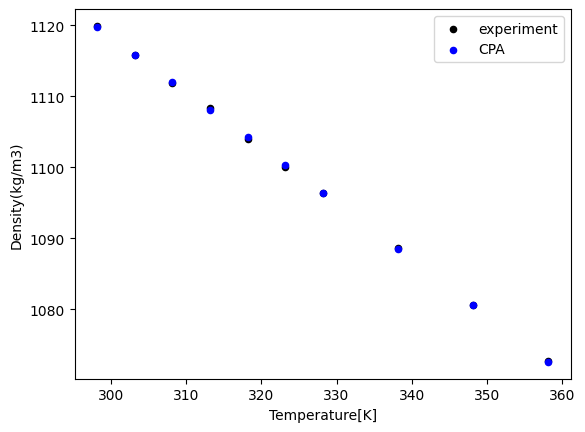

In [12]:
import neqsim
from neqsim.thermo.thermoTools import fluid, TPflash, fluidComposition,bubp
import pandas as pd
import numpy as np

fluid1 = fluid('cpa')
fluid1.addComponent('TEG', 1.0)
fluid1.setTemperature(25.0, 'C')
fluid1.setPressure(1.0, 'bara')
#fluid1.useVolumeCorrection(False)
print(' TC ', fluid1.getComponent('TEG').getTC())
print(' PC ', fluid1.getComponent('TEG').getPC())
print('Mat Cop Paramters 1 ', fluid1.getComponent('TEG').getAttractiveTerm().getParameters(0) , 'Mat Cop Paramters 2 ', fluid1.getComponent('TEG').getAttractiveTerm().getParameters(1) , 'Mat Cop Paramters 3 ', fluid1.getComponent('TEG').getAttractiveTerm().getParameters(2) )
print('Racket CPA ' , fluid1.getPhase(0).getComponent('TEG').getRacketZCPA())
print('vol corr T_CPA ' ,fluid1.getPhase(0).getComponent('TEG').getVolumeCorrectionT_CPA())
TPflash(fluid1)
#vol corr : 0.40768 * (0.29441 - this.getRacketZ()) * R * criticalTemperature / criticalPressure
volCorr = 0.40768 * (0.29441 - fluid1.getPhase(0).getComponent('TEG').getRacketZCPA()) * 8.314 * fluid1.getPhase(0).getComponent('TEG').getTC() / fluid1.getPhase(0).getComponent('TEG').getPC()
print('org cpa dens ', fluid1.getPhase(0).getMolarVolume()/1e5, ' ,m3/mol')
print('volcorr = a +b(T-288.15)')
print('a ', volCorr/1e5, ' m3/mol')
print('b ',fluid1.getPhase(0).getComponent('TEG').getVolumeCorrectionT_CPA(), 'm3/mol/K')
#volcorrCPA = volCorr + vol corr T * (liquidPhase.getPhase().getTemperature() - 288.15)) # molvol = molvolCPA + volcorrCPA m3/mol
print('vol corr ', volCorr/1e5 + fluid1.getPhase(0).getComponent('TEG').getVolumeCorrectionT_CPA()*(fluid1.getTemperature('K')-288.15)/1e5, ' m3/mol')

for phase in range(2):
    fluid1.getPhase(phase).getComponent('TEG').setRacketZCPA(0.284542458)
    fluid1.getPhase(phase).getComponent('TEG').setVolumeCorrectionT_CPA(-0.004423613)

def density(temp):
    fluid1.setTemperature(temp, 'K')
    TPflash(fluid1)
    fluid1.initProperties()
    return fluid1.getPhase('aqueous').getDensity('kg/m3')

temperatures = expdata_df['Temperature'].values.tolist()
dens_res = [density(T) for T in temperatures]

dataWithExperiment = expdata_df.assign(dens_CPA = dens_res)

from matplotlib import pyplot as plt
fig = plt.figure()	
plot1 = dataWithExperiment.plot(x='Temperature', y='Density', kind='scatter',ylabel='Density(kg/m3)', xlabel='Temperature[K]',color='black')	
dataWithExperiment.plot(ax=plot1, x='Temperature', y='dens_CPA', kind='scatter',ylabel='Density(kg/m3)', xlabel='Temperature[K]',color='blue')	
plt.legend(['experiment', 'CPA'])
plt.show()

## Automatic fitting